<a href="https://colab.research.google.com/github/angiegh2002/language_app/blob/main/arabic_reverse_dict_t5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!curl -X GET  "https://huggingface.co/api/datasets/riotu-lab/arabic_reverse_dictionary/parquet/default/train"

["https://huggingface.co/api/datasets/riotu-lab/arabic_reverse_dictionary/parquet/default/train/0.parquet"]

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

dataset = pd.read_parquet("/content/drive/MyDrive/Dataset data/data.parquet")


In [4]:
dataset.head()

,word,definition
0,تمنيع ذاتي,تحريض لاستجابة مناعية لبعض مكونات العضوية [الك...
1,مَسارٌ هاملتوني,مسار يمر عبر كل رأس في رسم بياني دون تكرار أي ...
2,الكلمة,أصغر وحدة لغوية تحمل معنى مستقل ويمكن استخدامه...
3,طرف,الجانبي جمع (طرفَة) وهو الغريبة من التمر [لغة]
4,الاسم,كلمة تدل على شيء أو شخص أو مكان وتستخدم عادة ف...


In [6]:
dataset.shape

(58607, 2)

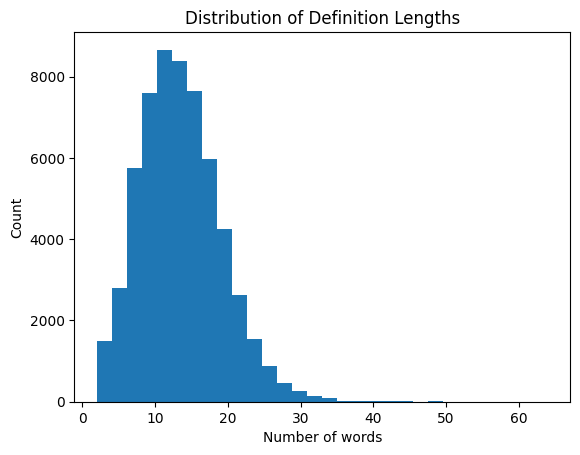

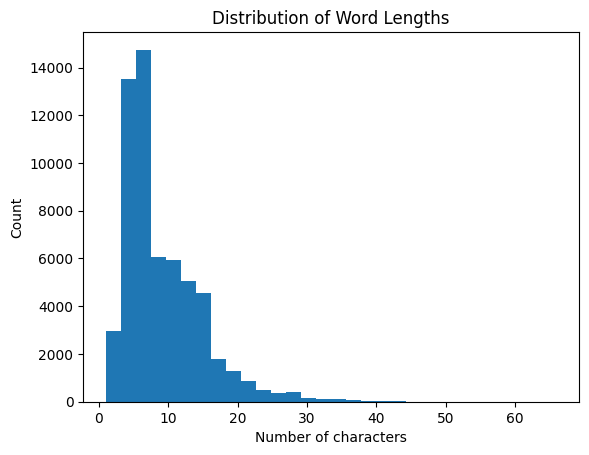

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
def_lengths = [len(str(row['definition']).split()) for index, row in dataset.iterrows() if row['definition'] is not None]
word_lengths = [len(str(row['word'])) for index, row in dataset.iterrows() if row['word'] is not None]

plt.hist(def_lengths, bins=30)
plt.title("Distribution of Definition Lengths")
plt.xlabel("Number of words")
plt.ylabel("Count")
plt.show()

plt.hist(word_lengths, bins=30)
plt.title("Distribution of Word Lengths")
plt.xlabel("Number of characters")
plt.ylabel("Count")
plt.show()

In [8]:
definitions = [row['definition'] for index, row in dataset.iterrows()]
words = [row['word'] for index, row in dataset.iterrows()]

print(f"Missing definitions: {sum([d is None for d in definitions])}")
print(f"Missing words: {sum([w is None for w in words])}")

print(f"Unique words: {len(set(words))}")

Missing definitions: 0
Missing words: 2
Unique words: 35617


In [9]:
dataset_clean = dataset.dropna(subset=['word'])
print(f"بعد التنظيف: {len(dataset_clean)} صف")


بعد التنظيف: 58605 صف


In [10]:
dataset_clean.duplicated().sum()

np.int64(61)

In [11]:
dataset_clean = dataset_clean.drop_duplicates()
print(f"بعد التنظيف: {len(dataset_clean)} صف")

بعد التنظيف: 58544 صف


In [12]:
import re
import pandas as pd

def clean_definition(text):
    # تأكد من أن النص نص (ليس NaN)
    if pd.isna(text) or not isinstance(text, str):
        return ""

    # 1. إزالة جميع التصنيفات بين [ ] بغض النظر عن مكانها
    #   (تعمل على [فيزياء]، [الكيمياء العضوية]، [التعلم العميق] و[الرؤية الحاسوبية] إلخ)
    text = re.sub(r'\s*\[[^\]]*\]\s*', ' ', text)

    # 2. إزالة الكلمات الإنجليزية (مثل: typically, tetradecanoic acid, GPT-4o)
    text = re.sub(r'\b[a-zA-Z]+\b', ' ', text)

    # 3. إزالة الرموز أو الأرقام المختلطة (مثل 4o)
    text = re.sub(r'\b\d+[a-zA-Z]*\d*\b', ' ', text)

    # 4. تنظيف المسافات الزائدة وعلامات الترقيم
    text = re.sub(r'\s+', ' ', text)           # مسافات متعددة → واحدة
    text = re.sub(r'\s+،\s*', '، ', text)     # تنسيق الفواصل
    text = re.sub(r'\s+\.+\s*', '. ', text)    # تنسيق النقاط
    text = re.sub(r'^[\s\.,،]+|[\s\.,،]+$', '', text)  # إزالة من البداية والنهاية

    return text.strip()

In [13]:
def preprocess(row):
    cleaned_definition = clean_definition(row['definition'])
    return pd.Series({
        "input_text": f" صف الكلمة التالية : {row['word']}",
        "target_text": cleaned_definition
    })

processed_df = dataset_clean.apply(preprocess, axis=1)


In [14]:
processed_df

,input_text,target_text
0,صف الكلمة التالية : تمنيع ذاتي,تحريض لاستجابة مناعية لبعض مكونات العضوية
1,صف الكلمة التالية : مَسارٌ هاملتوني,مسار يمر عبر كل رأس في رسم بياني دون تكرار أي رأس
2,صف الكلمة التالية : الكلمة,أصغر وحدة لغوية تحمل معنى مستقل ويمكن استخدامه...
3,صف الكلمة التالية : طرف,الجانبي جمع (طرفَة) وهو الغريبة من التمر
4,صف الكلمة التالية : الاسم,كلمة تدل على شيء أو شخص أو مكان وتستخدم عادة ف...
...,...,...
58602,صف الكلمة التالية : الاستفهام,طلب معرفة شيء أو تأكيده
58603,صف الكلمة التالية : السَّعْي إِذا كَانَ,التعبير عن المضي الجري والسعي نحو شيء ما
58604,صف الكلمة التالية : الحاجات,المتطلبات الأساسية أو الضرورية للإنسان
58605,صف الكلمة التالية : مُبَرّد بيني,مبادل حراري لتبريد الهواء بين مراحل الضغط المت...


In [15]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

model_name = "UBC-NLP/AraT5-base"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [16]:
from datasets import Dataset

dataset = Dataset.from_pandas(processed_df)

dataset_split = dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = dataset_split['train']
val_dataset = dataset_split['test']

In [17]:
from transformers import T5Tokenizer, T5ForConditionalGeneration, DataCollatorForSeq2Seq

tokenizer = T5Tokenizer.from_pretrained("UBC-NLP/AraT5-base")

def preprocess_function(examples):
    inputs = [inp for inp in examples["input_text"]]
    targets = [tgt for tgt in examples["target_text"]]

    model_inputs = tokenizer(inputs, max_length=128, truncation=True, padding="max_length", return_tensors=None)

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=128, truncation=True, padding="max_length", return_tensors=None)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_val = val_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/46835 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3950: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/11709 [00:00<?, ? examples/s]

In [38]:
# pip install -U transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 63.4 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.54.0
    Uninstalling transformers-4.54.0:
      Successfully uninstalled transformers-4.54.0


In [35]:
from transformers import Adafactor, TrainingArguments, Trainer, DataCollatorForSeq2Seq

training_args = TrainingArguments(
    output_dir="./arabict5-description-model",
    do_train=True,
    do_eval=True,
    learning_rate=3e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=100,
    save_steps=1000,
    eval_steps=1000,
    save_total_limit=2,
    fp16=True,
    report_to="none",         # ← هذا يعطل W&B تمامًا
    run_name="arabict5-run"   # ← لتفادي تحذير run_name
)
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)
optimizer = Adafactor(
    model.parameters(),
    scale_parameter=True,
    relative_step=False,  # ← مهم جدًا
    warmup_init=False,
    lr=3e-5               # ← لا تتركها None
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    optimizers=(optimizer, None)  # Explicitly set scheduler to None
)

/tmp/ipython-input-35-1608108391.py:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

Step,Training Loss


In [27]:
import torch
torch.cuda.empty_cache()


In [20]:
from transformers import TrainingArguments,Trainer

In [32]:
model = T5ForConditionalGeneration.from_pretrained("UBC-NLP/AraT5-base")

training_args = TrainingArguments(
    output_dir="./arabict5-description-model",
    eval_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=8,        # يمكن تقليله إلى 8 إذا نفذ الذاكرة
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=100,
    save_total_limit=2,
    load_best_model_at_end=True,
    report_to="none",
    fp16=True,         # تفعيل إذا كان لديك GPU
    push_to_hub=False  # يمكن تفعيله لرفع النموذج لاحقًا
)

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [33]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

/tmp/ipython-input-33-690231809.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


OutOfMemoryError: CUDA out of memory. Tried to allocate 324.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 6.12 MiB is free. Process 4104 has 14.73 GiB memory in use. Of the allocated memory 14.60 GiB is allocated by PyTorch, and 10.96 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
model.save_pretrained("/content/drive/MyDrive/arabict5-game-model")
tokenizer.save_pretrained("/content/drive/MyDrive/arabict5-game-model")